# Exploration and prediction of crime data from Hertfordshire constabullary

This notebook explains the data received from the Hertfordshire constabulary from May 2018 to April 2021; which can be downloaded at
https://data.police.uk/data/.

The notebook attempts to answer the key question:

1. Can we predict the likelihood of an offence being prosecuted,given information relating to the crime (type, time of year, location etc.)?

There are few major parts of this notebook that are outlined as following:
    
1. Data input
2. a.) Pre-conditioning and b.) predicting missing values
3. Exploratory Data Analysis
4. Data modelling
5. Summary 

The notebook serves as an interactive guide along with code for this data experience. It also provides flexibility to test different modelling schemes on the fly and compares the results accordingly.

## 1. Data Input

In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 



In [2]:
# Read the data
folpath= r'C:\Users\01-18-20\Documents\Job_Applications\CV_New\ADSP\3071be6e9772cef55f86d8ac989458a5c83d1733'
filepath = (glob.glob(folpath+"\**\*.csv"))

In [3]:
df = pd.concat(map(pd.read_csv, filepath))

In [48]:
# Display the few rows of the data
df.head(5)

Crime ID    Month  \
0                                                NaN  2018-05   
1  8fec1c2078e724240e7ac32d62a4ad76331680016c368d...  2018-05   
2  61652e75a172c325e652f275e09973e4fe412269f91956...  2018-05   
3                                                NaN  2018-05   
4                                                NaN  2018-05   

                  Reported by                Falls within  Longitude  \
0  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.684454   
1  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.209422   
2  Hertfordshire Constabulary  Hertfordshire Constabulary  -3.246861   
3  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.463497   
4  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.505670   

    Latitude                      Location  LSOA code               LSOA name  \
0  51.840077   On or near Cheddington Lane  E01017651     Aylesbury Vale 009A   
1  51.658891       On or near Calvert Road  E01000249             Barnet 001B   
2  54.091291          On or near Carr Lane  E01019187  Barrow-in-Furness 010E   
3  52.139261  On or near St Peter'S Street  E01017484            Bedford 009C   
4  52.114366      On or near Bartrum Close  E01017515            Bedford 018C   

                     Crime type  \
0         Anti-social behaviour   
1                      Burglary   
2  Violence and sexual offences   
3         Anti-social behaviour   
4         Anti-social behaviour   

                           Last outcome category  Context  
0                                            NaN      NaN  
1  Investigation complete; no suspect identified      NaN  
2                      Status update unavailable      NaN  
3                                            NaN      NaN  
4                                            NaN      NaN

In [5]:
# Check the dimensions of the data
df.shape

(325062, 12)

In [6]:
# to remove context and crime ID columns as they seems to be not useful for our work;
#  Crime ID have around 79000 missing values.
df1= df.drop(['Context','Crime ID'], axis = 1)
df1.head()



Month                 Reported by                Falls within  Longitude  \
0  2018-05  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.684454   
1  2018-05  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.209422   
2  2018-05  Hertfordshire Constabulary  Hertfordshire Constabulary  -3.246861   
3  2018-05  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.463497   
4  2018-05  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.505670   

    Latitude                      Location  LSOA code               LSOA name  \
0  51.840077   On or near Cheddington Lane  E01017651     Aylesbury Vale 009A   
1  51.658891       On or near Calvert Road  E01000249             Barnet 001B   
2  54.091291          On or near Carr Lane  E01019187  Barrow-in-Furness 010E   
3  52.139261  On or near St Peter'S Street  E01017484            Bedford 009C   
4  52.114366      On or near Bartrum Close  E01017515            Bedford 018C   

                     Crime type                          Last outcome category  
0         Anti-social behaviour                                            NaN  
1                      Burglary  Investigation complete; no suspect identified  
2  Violence and sexual offences                      Status update unavailable  
3         Anti-social behaviour                                            NaN  
4         Anti-social behaviour                                            NaN

## 2. a.) Data pre-conditiong 

In [7]:
# show the concise summary about data and count missing values in the dataframe
df1.info()
df1.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 325062 entries, 0 to 8421
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Month                  325062 non-null  object 
 1   Reported by            325062 non-null  object 
 2   Falls within           325062 non-null  object 
 3   Longitude              321768 non-null  float64
 4   Latitude               321768 non-null  float64
 5   Location               325062 non-null  object 
 6   LSOA code              321768 non-null  object 
 7   LSOA name              321768 non-null  object 
 8   Crime type             325062 non-null  object 
 9   Last outcome category  245452 non-null  object 
dtypes: float64(2), object(8)
memory usage: 27.3+ MB


Month                        0
Reported by                  0
Falls within                 0
Longitude                 3294
Latitude                  3294
Location                     0
LSOA code                 3294
LSOA name                 3294
Crime type                   0
Last outcome category    79610
dtype: int64

In [52]:
# remove missing values and verify

df2 = df1.dropna( how='any',
                    subset=['Longitude', 'Latitude', 'LSOA code', 'LSOA name'])

In [53]:
df2.isna().sum()

Month                        0
Reported by                  0
Falls within                 0
Longitude                    0
Latitude                     0
Location                     0
LSOA code                    0
LSOA name                    0
Crime type                   0
Last outcome category    79528
dtype: int64

In [54]:
#Rename the column called 'Last outcome category'
df2.rename(columns = {'Last outcome category':'Last_outcome_category'}, inplace = True)

#df2["Last_outcome_category"].value_counts()


C:\Users\01-18-20\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [55]:
# convert date into datetime and create new columns
df2['Month']=pd.to_datetime(df2['Month'])

df2['year']=df2['Month'].apply(lambda x:x.year)
df2['Months']=df2['Month'].apply(lambda x:x.month)

data =df2.drop(['Month'],1)
data.head()


<ipython-input-55-f7efd05c74d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month']=pd.to_datetime(df2['Month'])
<ipython-input-55-f7efd05c74d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year']=df2['Month'].apply(lambda x:x.year)
<ipython-input-55-f7efd05c74d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Reported by                Falls within  Longitude  \
0  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.684454   
1  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.209422   
2  Hertfordshire Constabulary  Hertfordshire Constabulary  -3.246861   
3  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.463497   
4  Hertfordshire Constabulary  Hertfordshire Constabulary  -0.505670   

    Latitude                      Location  LSOA code               LSOA name  \
0  51.840077   On or near Cheddington Lane  E01017651     Aylesbury Vale 009A   
1  51.658891       On or near Calvert Road  E01000249             Barnet 001B   
2  54.091291          On or near Carr Lane  E01019187  Barrow-in-Furness 010E   
3  52.139261  On or near St Peter'S Street  E01017484            Bedford 009C   
4  52.114366      On or near Bartrum Close  E01017515            Bedford 018C   

                     Crime type  \
0         Anti-social behaviour   
1                      Burglary   
2  Violence and sexual offences   
3         Anti-social behaviour   
4         Anti-social behaviour   

                           Last_outcome_category  year  Months  
0                                            NaN  2018       5  
1  Investigation complete; no suspect identified  2018       5  
2                      Status update unavailable  2018       5  
3                                            NaN  2018       5  
4                                            NaN  2018       5

In [56]:
# create the new datafram which has null value in the dataframe
df3 = df2[df2.isna().any(axis=1)]
df3["Crime type"].value_counts()
df3


Month                 Reported by                Falls within  \
0    2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
3    2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
4    2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
5    2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
6    2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
...         ...                         ...                         ...   
8251 2021-04-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
8265 2021-04-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
8266 2021-04-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
8278 2021-04-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
8279 2021-04-01  Hertfordshire Constabulary  Hertfordshire Constabulary   

      Longitude   Latitude                       Location  LSOA code  \
0     -0.684454  51.840077    On or near Cheddington Lane  E01017651   
3     -0.463497  52.139261   On or near St Peter'S Street  E01017484   
4     -0.505670  52.114366       On or near Bartrum Close  E01017515   
5      0.000767  51.777147    On or near Cranbourne Drive  E01023316   
6     -0.012505  51.775321      On or near Beyers Gardens  E01023317   
...         ...        ...                            ...        ...   
8251  -0.114318  51.703748         On or near South Drive  E01023947   
8265  -0.117857  51.709137  On or near Cranfield Crescent  E01023948   
8266  -0.114463  51.713831        On or near Tolmers Road  E01023948   
8278  -0.113757  51.716895  On or near Brookside Crescent  E01023949   
8279  -0.113757  51.716895  On or near Brookside Crescent  E01023949   

                 LSOA name             Crime type Last_outcome_category  year  \
0      Aylesbury Vale 009A  Anti-social behaviour                   NaN  2018   
3             Bedford 009C  Anti-social behaviour                   NaN  2018   
4             Bedford 018C  Anti-social behaviour                   NaN  2018   
5          Broxbourne 001A  Anti-social behaviour                   NaN  2018   
6          Broxbourne 001B  Anti-social behaviour                   NaN  2018   
...                    ...                    ...                   ...   ...   
8251  Welwyn Hatfield 016A  Anti-social behaviour                   NaN  2021   
8265  Welwyn Hatfield 016B  Anti-social behaviour                   NaN  2021   
8266  Welwyn Hatfield 016B  Anti-social behaviour                   NaN  2021   
8278  Welwyn Hatfield 016C  Anti-social behaviour                   NaN  2021   
8279  Welwyn Hatfield 016C  Anti-social behaviour                   NaN  2021   

      Months  
0          5  
3          5  
4          5  
5          5  
6          5  
...      ...  
8251       4  
8265       4  
8266       4  
8278       4  
8279       4  

[79528 rows x 12 columns]

## 2. b.) Predicting missing values in the Dataset

In [57]:
# covert the categorical columns in to numerical one
ord_enc = OrdinalEncoder()
#data2["abilityLevel_code"] = ord_enc.fit_transform(data2[["abilityLevel"]])
data["Reported by"] = ord_enc.fit_transform(data[["Reported by"]])
data["Falls within"] = ord_enc.fit_transform(data[["Falls within"]])
data["Location"] = ord_enc.fit_transform(data[["Location"]])
data["LSOA code"] = ord_enc.fit_transform(data[["LSOA code"]])
data["LSOA name"] = ord_enc.fit_transform(data[["LSOA name"]])
data["Crime type"] = ord_enc.fit_transform(data[["Crime type"]])


In [58]:

Training_data = data.dropna()
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'Last_outcome_category'. 
Training_data['Last_outcome_category1']= label_encoder.fit_transform(Training_data['Last_outcome_category'])  
predict_data = data[data["Last_outcome_category"].isna()]


Training_data.shape, predict_data.shape

<ipython-input-58-cf2b4fc5d2bd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Training_data['Last_outcome_category1']= label_encoder.fit_transform(Training_data['Last_outcome_category'])


((242240, 12), (79528, 11))

In [59]:
predict_data.head()

Reported by  Falls within  Longitude   Latitude  Location  LSOA code  \
0          0.0           0.0  -0.684454  51.840077    1833.0     1027.0   
3          0.0           0.0  -0.463497  52.139261    8610.0      987.0   
4          0.0           0.0  -0.505670  52.114366     623.0      998.0   
5          0.0           0.0   0.000767  51.777147    2346.0     1250.0   
6          0.0           0.0  -0.012505  51.775321     866.0     1251.0   

   LSOA name  Crime type Last_outcome_category  year  Months  
0        8.0         0.0                   NaN  2018       5  
3      167.0         0.0                   NaN  2018       5  
4      176.0         0.0                   NaN  2018       5  
5      290.0         0.0                   NaN  2018       5  
6      291.0         0.0                   NaN  2018       5

In [60]:
Training_data[['Last_outcome_category', 'Last_outcome_category1']].value_counts()

Last_outcome_category                                Last_outcome_category1
Investigation complete; no suspect identified        9                         95473
Unable to prosecute suspect                          25                        88096
Status update unavailable                            23                        15844
Court result unavailable                             3                         12065
Under investigation                                  26                         9556
Awaiting court outcome                               1                          4407
Local resolution                                     10                         4240
Offender given a caution                             13                         3906
Action to be taken by another organisation           0                          2302
Offender given a drugs possession warning            14                         1225
Formal action is not in the public interest          6                    

In [61]:
Training_data1 = Training_data.drop(['Last_outcome_category'], 1)

In [62]:
y_train = Training_data1['Last_outcome_category1']
x_train = Training_data1.drop('Last_outcome_category1', axis = 1)
x_test =  predict_data.drop('Last_outcome_category', axis = 1)
y_test = predict_data['Last_outcome_category']

In [63]:
# summarize
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)


Train (242240, 10) (242240,)
Test (79528, 10) (79528,)


In [64]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [65]:
y_pred = knn.predict(x_test)
df2.loc[df2.Last_outcome_category.isna(), 'Last_outcome_category'] = y_pred
df2.head()

C:\Users\01-18-20\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Month                 Reported by                Falls within  \
0 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
1 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
2 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
3 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
4 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   

   Longitude   Latitude                      Location  LSOA code  \
0  -0.684454  51.840077   On or near Cheddington Lane  E01017651   
1  -0.209422  51.658891       On or near Calvert Road  E01000249   
2  -3.246861  54.091291          On or near Carr Lane  E01019187   
3  -0.463497  52.139261  On or near St Peter'S Street  E01017484   
4  -0.505670  52.114366      On or near Bartrum Close  E01017515   

                LSOA name                    Crime type  \
0     Aylesbury Vale 009A         Anti-social behaviour   
1             Barnet 001B                      Burglary   
2  Barrow-in-Furness 010E  Violence and sexual offences   
3            Bedford 009C         Anti-social behaviour   
4            Bedford 018C         Anti-social behaviour   

                           Last_outcome_category  year  Months  
0                                             26  2018       5  
1  Investigation complete; no suspect identified  2018       5  
2                      Status update unavailable  2018       5  
3                                              9  2018       5  
4                                              9  2018       5

In [66]:
df2.isna().sum()
df2.head()

Month                 Reported by                Falls within  \
0 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
1 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
2 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
3 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
4 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   

   Longitude   Latitude                      Location  LSOA code  \
0  -0.684454  51.840077   On or near Cheddington Lane  E01017651   
1  -0.209422  51.658891       On or near Calvert Road  E01000249   
2  -3.246861  54.091291          On or near Carr Lane  E01019187   
3  -0.463497  52.139261  On or near St Peter'S Street  E01017484   
4  -0.505670  52.114366      On or near Bartrum Close  E01017515   

                LSOA name                    Crime type  \
0     Aylesbury Vale 009A         Anti-social behaviour   
1             Barnet 001B                      Burglary   
2  Barrow-in-Furness 010E  Violence and sexual offences   
3            Bedford 009C         Anti-social behaviour   
4            Bedford 018C         Anti-social behaviour   

                           Last_outcome_category  year  Months  
0                                             26  2018       5  
1  Investigation complete; no suspect identified  2018       5  
2                      Status update unavailable  2018       5  
3                                              9  2018       5  
4                                              9  2018       5

In [67]:
df2["Last_outcome_category"].value_counts()

Investigation complete; no suspect identified          95473
Unable to prosecute suspect                            88096
9                                                      63808
Status update unavailable                              15844
Court result unavailable                               12065
25                                                      9679
Under investigation                                     9556
Awaiting court outcome                                  4407
Local resolution                                        4240
Offender given a caution                                3906
Action to be taken by another organisation              2302
3                                                       1839
23                                                      1745
Offender given a drugs possession warning               1225
Formal action is not in the public interest              754
Offender fined                                           737
Offender sent to prison 

In [68]:
df2["Last_outcome_category"] = df2['Last_outcome_category'].replace({9:'Investigation complete; no suspect identified', 25 : 'Unable to prosecute suspect',
                                                                     23:'Status update unavailable', 3:'Court result unavailable', 1:'Court result unavailable',
                                                                     10:'Local resolution', 26:'Under investigation',13:'Offender given a caution', 0:'Action to be taken by another organisation',
                                                                     14:'Offender given a drugs possession warning', 24:'Suspect charged as part of another case', 8:'Further investigation is not in the public interest',
                                                                     4:'Defendant found not guilty', 16:'Offender given community sentence', 6:'Formal action is not in the public interest', 12:'Offender fined',
                                                                     5:'Defendant sent to Crown Court', 19:'Offender given suspended prison sentence', 17:'Offender given conditional discharge', 7:'Further action is not in the public interest',22:'Offender sent to prison', 18:'Offender given penalty notice', 2:'Court case unable to proceed'})
                                                                     
                                                                     

<ipython-input-68-c88129772270>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Last_outcome_category"] = df2['Last_outcome_category'].replace({9:'Investigation complete; no suspect identified', 25 : 'Unable to prosecute suspect',


In [69]:
# Insert the new column called Prosecuted_outcome
df2['prosecuted_outcome'] = df2['Last_outcome_category'].replace({'Investigation complete; no suspect identified':'no', 'Unable to prosecute suspect':'no', 'Status update unavailable' : 'no',
                                                                     'Court result unavailable' : 'no', 'Under investigation' : 'no', 'Awaiting court outcome' : 'yes', 'Local resolution' : 'no',
                                                                   'Offender given a caution':'no', 'Action to be taken by another organisation':'no', 'Offender given a drugs possession warning':'no',
                                                                   'Formal action is not in the public interest':'no','Offender fined':'yes', 'Offender sent to prison':'yes', 'Offender given community sentence':'yes', 
                                                                   'Further investigation is not in the public interest':'no', 'Offender given penalty notice':'no', 'Offender given suspended prison sentence':'yes',
                                                                   'Defendant found not guilty':'yes', 'Court case unable to proceed':'no', 'Offender given conditional discharge' :'yes', 'Suspect charged as part of another case':'no',
                                                                   'Offender ordered to pay compensation':'no', 'Further action is not in the public interest':'no', 
                                                                   'Offender otherwise dealt with':'no', 'Defendant sent to Crown Court':'yes', 'Offender deprived of property':'yes','Offender given absolute discharge':'yes' })
df2["prosecuted_outcome"].value_counts()
df2.head()

<ipython-input-69-cb89e6bf1dd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['prosecuted_outcome'] = df2['Last_outcome_category'].replace({'Investigation complete; no suspect identified':'no', 'Unable to prosecute suspect':'no', 'Status update unavailable' : 'no',


Month                 Reported by                Falls within  \
0 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
1 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
2 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
3 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
4 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   

   Longitude   Latitude                      Location  LSOA code  \
0  -0.684454  51.840077   On or near Cheddington Lane  E01017651   
1  -0.209422  51.658891       On or near Calvert Road  E01000249   
2  -3.246861  54.091291          On or near Carr Lane  E01019187   
3  -0.463497  52.139261  On or near St Peter'S Street  E01017484   
4  -0.505670  52.114366      On or near Bartrum Close  E01017515   

                LSOA name                    Crime type  \
0     Aylesbury Vale 009A         Anti-social behaviour   
1             Barnet 001B                      Burglary   
2  Barrow-in-Furness 010E  Violence and sexual offences   
3            Bedford 009C         Anti-social behaviour   
4            Bedford 018C         Anti-social behaviour   

                           Last_outcome_category  year  Months  \
0                            Under investigation  2018       5   
1  Investigation complete; no suspect identified  2018       5   
2                      Status update unavailable  2018       5   
3  Investigation complete; no suspect identified  2018       5   
4  Investigation complete; no suspect identified  2018       5   

  prosecuted_outcome  
0                 no  
1                 no  
2                 no  
3                 no  
4                 no

## 3. Exploratory Data Analysis

In [70]:
df2.head()

Month                 Reported by                Falls within  \
0 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
1 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
2 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
3 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   
4 2018-05-01  Hertfordshire Constabulary  Hertfordshire Constabulary   

   Longitude   Latitude                      Location  LSOA code  \
0  -0.684454  51.840077   On or near Cheddington Lane  E01017651   
1  -0.209422  51.658891       On or near Calvert Road  E01000249   
2  -3.246861  54.091291          On or near Carr Lane  E01019187   
3  -0.463497  52.139261  On or near St Peter'S Street  E01017484   
4  -0.505670  52.114366      On or near Bartrum Close  E01017515   

                LSOA name                    Crime type  \
0     Aylesbury Vale 009A         Anti-social behaviour   
1             Barnet 001B                      Burglary   
2  Barrow-in-Furness 010E  Violence and sexual offences   
3            Bedford 009C         Anti-social behaviour   
4            Bedford 018C         Anti-social behaviour   

                           Last_outcome_category  year  Months  \
0                            Under investigation  2018       5   
1  Investigation complete; no suspect identified  2018       5   
2                      Status update unavailable  2018       5   
3  Investigation complete; no suspect identified  2018       5   
4  Investigation complete; no suspect identified  2018       5   

  prosecuted_outcome  
0                 no  
1                 no  
2                 no  
3                 no  
4                 no

In [75]:
map_df = df2[(df2['year']==2020)]# & (df2['Months']== 6) & (df2['Crime type']=='Violence and sexual offences')]
crime_locations = list(zip(map_df.Latitude, periodic_df.Longitude))

# generate map
base_map = folium.Map(location=[51.5074, 0.1277], zoom_start=10)
heatmap = plugins.HeatMap(crime_locations, radius=5, blur=2)
base_map.add_child(heatmap)

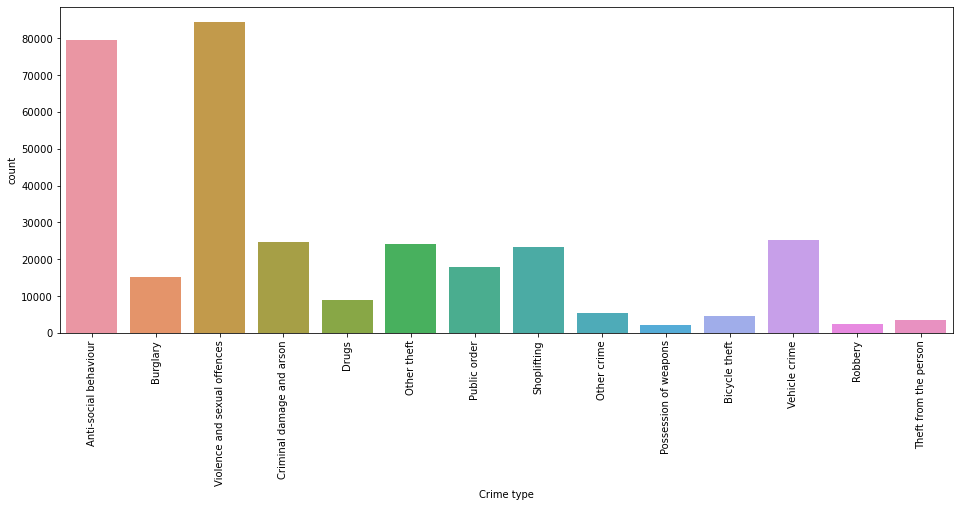

In [28]:
df2.groupby('Crime type').size()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
sns.countplot(x = "Crime type", data = df2);
plt.xticks(rotation=90)
plt.show()

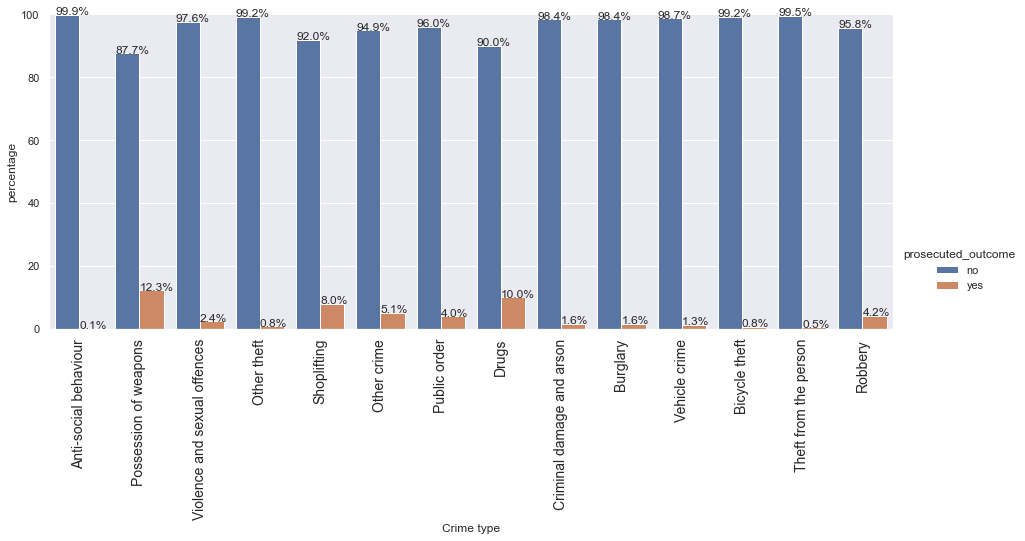

In [29]:
sns.set(rc={'figure.figsize':(109.7,48.27)})

crime_type_counts1 = (df2.groupby(['Crime type'])['prosecuted_outcome']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('prosecuted_outcome'))
g = sns.catplot(x="Crime type",y='percentage',hue='prosecuted_outcome',kind='bar',data=crime_type_counts1, height = 5, aspect = 2.5)
g.ax.set_ylim(0,100)
plt.xticks(fontsize=14, rotation=90)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

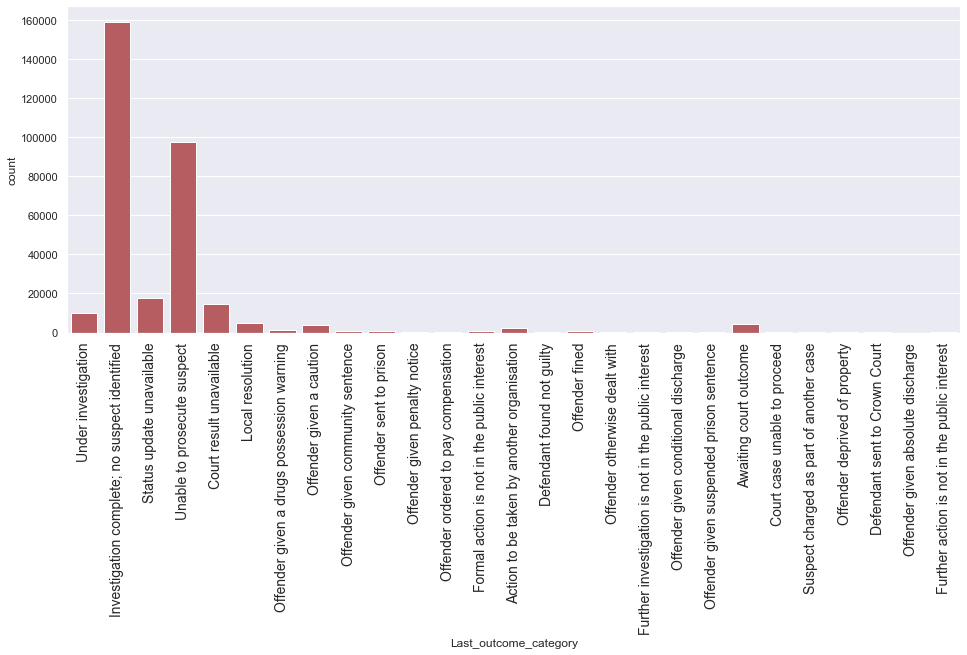

In [30]:
plt.figure(figsize=(16, 6))
sns.countplot(x = "Last_outcome_category", data = df2, color = 'r');
plt.xticks(fontsize=14, rotation=90)
plt.show()

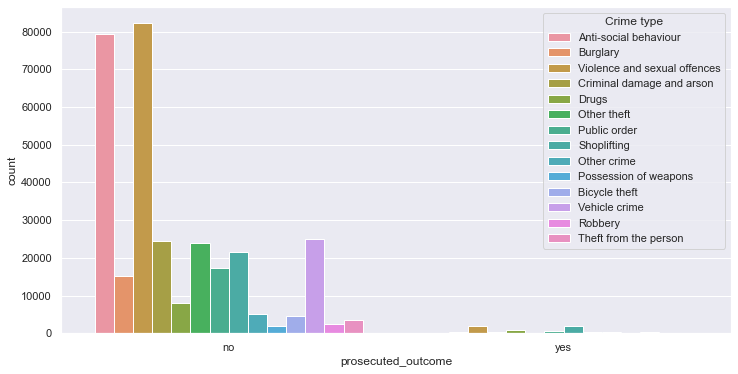

In [31]:
plt.figure(figsize=(12,6))
#plt.title('The relationship between topic and nationality')
sns.countplot(x='prosecuted_outcome', hue = 'Crime type', data=df2)
plt.show()


no     314322
yes      7446
Name: prosecuted_outcome, dtype: int64


([<matplotlib.patches.Wedge at 0x2782a9af3d0>,
 [Text(-0.08207786978313407, -1.1270151832570239, 'no'),
  Text(0.11621650881794768, 1.5957737067260407, 'yes')],
 [Text(-0.045760228286172086, -0.628335898630022, '97.7%'),
  Text(0.07989884981233902, 1.0970944233741529, '2.3%')])

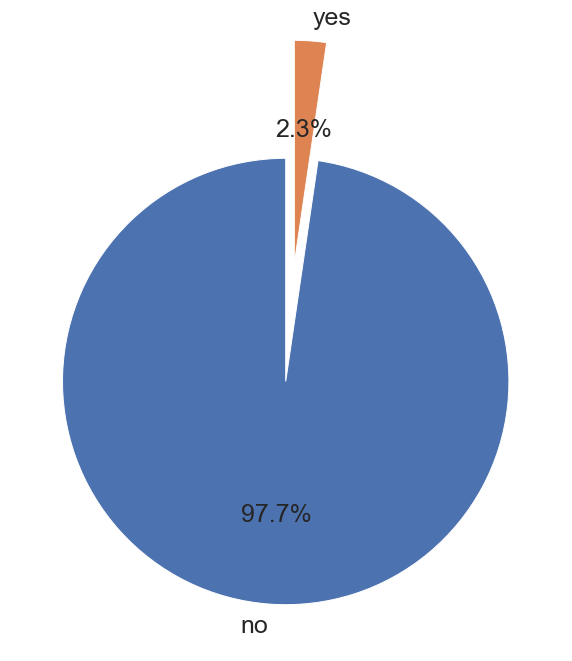

In [32]:
# show the percentage of yes and no label
df_type = pd.value_counts(df2['prosecuted_outcome'])
print(df_type)
labels = ['no', 'yes']
colors = ['red', 'blue']
#plt.title('Relationship between organic and conventional avocado')
explode = [0.03,0.5]
textprops = {"fontsize":25} # Font size of text in pie chart
plt.figure(figsize=(10,12))
plt.pie(df_type,labels= labels, explode = explode, startangle=90, autopct='%1.1f%%', textprops =textprops)

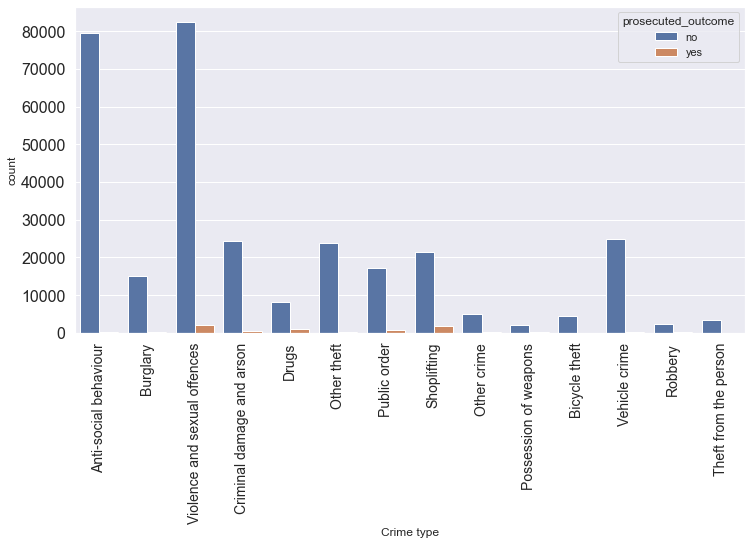

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x='Crime type', hue= 'prosecuted_outcome', data=df2)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=16)
plt.show()

## 4. Data Modelling


Model the data for binary classification problem

#### a.)Transform the data for modelling

In [34]:
ord_enc = OrdinalEncoder()
#data2["abilityLevel_code"] = ord_enc.fit_transform(data2[["abilityLevel"]])
df2["Reported by"] = ord_enc.fit_transform(df2[["Reported by"]])
df2["Falls within"] = ord_enc.fit_transform(df2[["Falls within"]])
df2["Location"] = ord_enc.fit_transform(df2[["Location"]])
df2["LSOA code"] = ord_enc.fit_transform(df2[["LSOA code"]])
df2["LSOA name"] = ord_enc.fit_transform(df2[["LSOA name"]])
df2["Crime type"] = ord_enc.fit_transform(df2[["Crime type"]])

label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'prosecuted_outcome'. 
df2['prosecuted_outcome']= label_encoder.fit_transform(df2['prosecuted_outcome']) 
#predict_data = data[data["Last_outcome_category"].isna()]
data1 = df2.drop(['Month','Last_outcome_category', 'Falls within', 'Reported by'], axis = 1)
data1.head()


<ipython-input-34-831d1fdd12b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Reported by"] = ord_enc.fit_transform(df2[["Reported by"]])
<ipython-input-34-831d1fdd12b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Falls within"] = ord_enc.fit_transform(df2[["Falls within"]])
<ipython-input-34-831d1fdd12b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Longitude   Latitude  Location  LSOA code  LSOA name  Crime type  year  \
0  -0.684454  51.840077    1833.0     1027.0        8.0         0.0  2018   
1  -0.209422  51.658891    1539.0       74.0       48.0         2.0  2018   
2  -3.246861  54.091291    1640.0     1112.0      149.0        13.0  2018   
3  -0.463497  52.139261    8610.0      987.0      167.0         0.0  2018   
4  -0.505670  52.114366     623.0      998.0      176.0         0.0  2018   

   Months  prosecuted_outcome  
0       5                   0  
1       5                   0  
2       5                   0  
3       5                   0  
4       5                   0

In [35]:
data1.head()
data1["prosecuted_outcome"].value_counts()

0    314322
1      7446
Name: prosecuted_outcome, dtype: int64

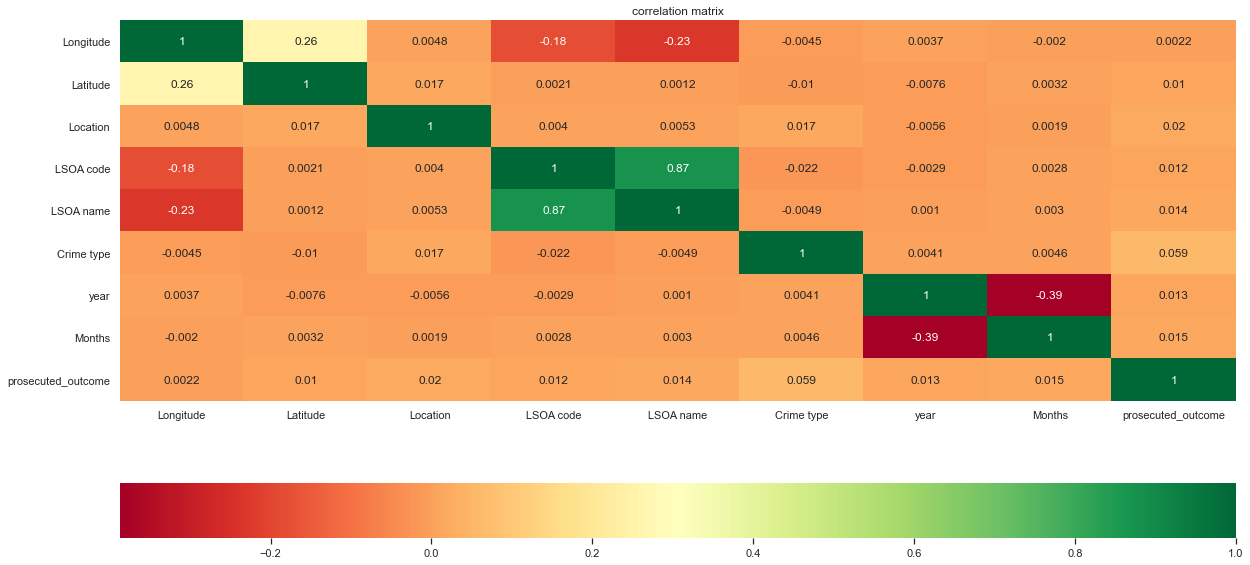

In [36]:
plt.figure(figsize=(20,10))
plt.title('correlation matrix')
sns.heatmap(data1.corr(), cmap = 'RdYlGn', annot = True, cbar_kws={"orientation": "horizontal"} )
plt.rcParams.update({'font.size': 22})
plt.show()


##### b.) Split the data in to training and test data

In [37]:
data2 = data1.drop('LSOA name', 1)
# split the dataset into training and test data
labels = data2['prosecuted_outcome']
# Remove the labels from the features
features= data2.drop('prosecuted_outcome', axis = 1)
features

Longitude   Latitude  Location  LSOA code  Crime type  year  Months
0     -0.684454  51.840077    1833.0     1027.0         0.0  2018       5
1     -0.209422  51.658891    1539.0       74.0         2.0  2018       5
2     -3.246861  54.091291    1640.0     1112.0        13.0  2018       5
3     -0.463497  52.139261    8610.0      987.0         0.0  2018       5
4     -0.505670  52.114366     623.0      998.0         0.0  2018       5
...         ...        ...       ...        ...         ...   ...     ...
8278  -0.113757  51.716895    1307.0     1876.0         0.0  2021       4
8279  -0.113757  51.716895    1307.0     1876.0         0.0  2021       4
8280  -0.114586  51.716441    4652.0     1876.0        12.0  2021       4
8281  -0.166915  51.531928    7360.0      730.0        13.0  2021       4
8282  -1.788238  51.103741    8451.0     2047.0        11.0  2021       4

[321768 rows x 7 columns]

Class=0, n=314322 (50.000%)
Class=1, n=314322 (50.000%)


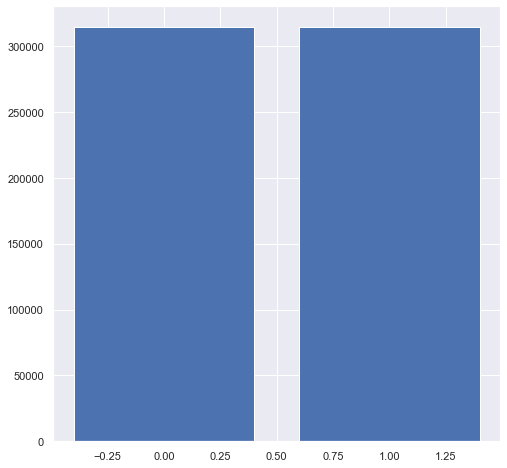

In [38]:
# transform the dataset
oversample = SMOTE()
features, labels = oversample.fit_resample(features, labels)
# summarize distribution
counter = Counter(labels)
for k,v in counter.items():
    per = v / len(labels) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# plot the distribution
plt.figure(figsize=(8,8))
plt.bar(counter.keys(), counter.values())
plt.show()

In [39]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.30, random_state = 1)
print( train_features.shape, train_labels.shape)
print (test_features.shape, test_labels.shape)
#test_features.head()
#print(test_features.head())
#print(test_labels.head())

(440050, 7) (440050,)
(188594, 7) (188594,)


In [40]:
from sklearn.linear_model import LogisticRegression
# Check Algorithms which one work on the given data
models = []

models.append(('RFC', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, train_features,train_labels, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

RFC: 0.970342 (0.000608)
KNN: 0.926499 (0.000568)
LR: 0.602547 (0.001972)


In [41]:
# Make predictions on validation dataset
model = RandomForestClassifier()
model.fit(train_features,train_labels)
predictions = model.predict(test_features)

print(accuracy_score(test_labels, predictions))


0.9707519857471606


In [42]:
#result_train = model.score(train_features,train_labels)
#print(result_train)

In [43]:
#import pickle

# save the model to disk
#filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))


In [44]:
# load the model from disk
#loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
#predictions = loaded_model.predict(test_features)
#result_train = loaded_model.score(train_features,train_labels)

#result_test = loaded_model.score(test_features,test_labels)
#print(result_train), print(result_test)

In [45]:
#inpu = [[-0.684454,51.840077,1833.0,1027.0,8.0,0.0,2018,5]]

#predictions = loaded_model.predict(inpu)
#predictions

In [46]:
# Evaluate predictions
print(accuracy_score(test_labels, predictions))
#print(confusion_matrix(test_labels, predictions))
print(classification_report(test_labels, predictions))

0.9707519857471606
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     94314
           1       0.96      0.98      0.97     94280

    accuracy                           0.97    188594
   macro avg       0.97      0.97      0.97    188594
weighted avg       0.97      0.97      0.97    188594



[[90952  3362]
 [ 2154 92126]]


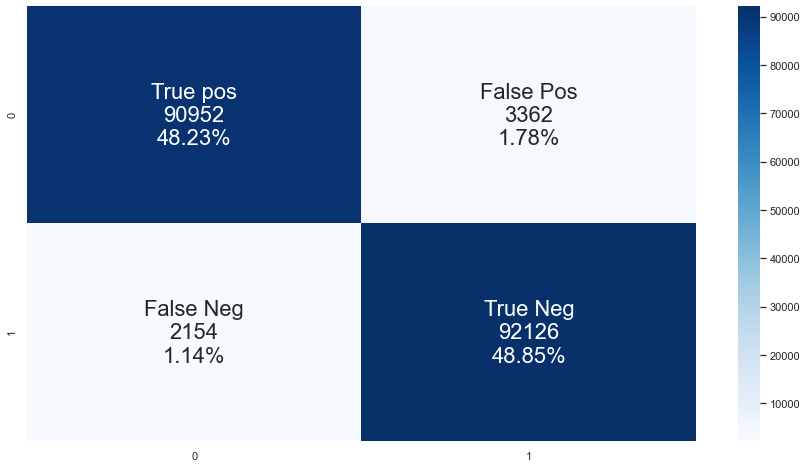

In [47]:
#Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, predictions)
print(cf_matrix)
group_names = ['True pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,8))
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.rcParams.update({'font.size': 30})

# 5. Summary

The study explores the data collected by Hertfordshire constabulary for different crime types between the years 2018 and 2021. As a reminder to us, this study is focused on answering the key question:

1.Can we predict the likelihood of an offense being prosecuted, given information relating to the crime (type, time of year, location, etc.)?

First of all, the data exploration has been useful in terms of ascertaining the patterns of different crime types. In general, from a map view, it can be established that there are certain areas that can be identified as crime hotspots. This could be further broken down in establishing which crime types are prevalent in which area; however, in an overall observation the crime type "Anti-social behavior" seems to be one of the most reported crime everywhere, and interestingly is the least prosecuted crime as well. The "Violence and sexual offenses" is the highest reported crime but are at the 7th place in terms of prosecution.

The data seems to have a significant number of missing values in few columns which required some preconditioning. The KNN (K-nearest neighbor) modeling approach has been very successful in predicting these missing values. Further data analysis suggests that there needs to be a labeling approach required to perform the classification task of whether a crime will be prosecuted or not. The labeling was simply done by understanding the outcome column values and categorizing various results in two labels by a simple approach. This could be further broken down into multiple labels such as "may-be".

Different machine learning models were applied initially, but the data seems to be very much skewed and imbalanced in between two labels and more than 90% of values were falling under one label. The Synthetic Minority Oversampling Technique (SMOTE) was applied to perform the balance in sampling between two labels. This resulted in good prediction and minimized the overfitting of the models.

In the end, the random forest seems to be the best fit model for this classification task and performed the task with up to 97% accuracy.

As a few highlights my observations are as following:

1. The collected data by Hertfordshire constabulary is very useful in identifying the crime hotspots and a number of different meaningful observations which can provide insights in updating the police operations and government planning.

2. The data seemed to be a little noisy and upon labeling bit imbalanced but this can be handled with routine techniques.

3. The prediction using tree-based algorithms is useful to predict the likelihood of the outcome which can be evolved further by different feature engineering approaches.

Thanks for your patience.